In [1]:
!date

Wed Feb  5 22:42:48 PST 2020


In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from scipy import stats
from scipy.optimize import curve_fit
import ast
from scipy.stats import sem
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp, ttest_ind
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
gene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# New t2g

In [3]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)

In [4]:
def swap_start(start, stop, strand):
    new_start = start
    new_stop = stop
    if strand=="-":
        new_start = stop
        new_stop = start
    return new_start, new_stop

In [5]:
tmp = t2g.apply(lambda x: swap_start(x["start"], x["stop"], x["strand"]), axis=1).tolist()
t2g[["new_start", "new_stop"]] = pd.DataFrame(tmp, columns=["new_start", "new_stop"])

# Group isoforms by (1) Gene and then (2) Transcripton start sites

In [6]:
gb = t2g.groupby(["chromosome", "gene_id", "new_start"])["transcript_id"].apply(list)
gb = gb.reset_index()
gb = gb.rename(columns={"transcript_id":"tss_same"})
gb["n_tss_same"] = gb["tss_same"].apply(lambda x: len(x))
num_iso_per_gene = t2g.groupby("gene_id")["transcript_id"].nunique()
gb["n_iso"] = gb["gene_id"].map(num_iso_per_gene)
txn_list = gb["tss_same"].explode().values

In [9]:
gb

,chromosome,gene_id,new_start,tss_same,n_tss_same,n_iso
0,1,ENSMUSG00000000544.14,166130238,[ENSMUST00000060833.13],1,4
1,1,ENSMUSG00000000544.14,166130340,[ENSMUST00000166159.1],1,4
2,1,ENSMUSG00000000544.14,166130417,[ENSMUST00000027847.6],1,4
3,1,ENSMUSG00000000544.14,166130467,[ENSMUST00000166860.1],1,4
4,1,ENSMUSG00000000817.10,161788358,[ENSMUST00000193648.1],1,2
...,...,...,...,...,...,...
102881,Y,ENSMUSG00000104500.5,24276742,[ENSMUST00000194949.5],1,3
102882,Y,ENSMUSG00000104505.5,12516355,"[ENSMUST00000191901.5, ENSMUST00000193731.1]",2,3
102883,Y,ENSMUSG00000104505.5,12516809,[ENSMUST00000191742.5],1,3
102884,Y,ENSMUSG00000104506.5,19983060,"[ENSMUST00000193523.5, ENSMUST00000194757.1]",2,2


In [12]:
#gb = gb.loc[gb.index.repeat(gb.n_TSS_same)].reset_index(drop=True)
#gb["transcript_id"] = txn_list

Now GB has TSS_same which is the list of transcripts in the covering gene that have the same start site

In [15]:
gb["tss_same"] = gb.tss_same.astype(str)

In [17]:
#gb.drop_duplicates(subset=["chromosome", "gene_id", "tss_same"]).shape
gb["tss_class"] = np.arange(gb.shape[0])

Transcripts are grouped by Chromosome -> Gene -> TSS same

Want to make a matrix which is cells x tss_same

Then perform t test between clusters, this tells you which TSS same mark the cluster

but want to compare TSS same with just isoforms only... am missing something, ah yes, sleep!

In [19]:
gb.head()

,chromosome,gene_id,new_start,tss_same,n_tss_same,n_iso,tss_class
0,1,ENSMUSG00000000544.14,166130238,['ENSMUST00000060833.13'],1,4,0
1,1,ENSMUSG00000000544.14,166130340,['ENSMUST00000166159.1'],1,4,1
2,1,ENSMUSG00000000544.14,166130417,['ENSMUST00000027847.6'],1,4,2
3,1,ENSMUSG00000000544.14,166130467,['ENSMUST00000166860.1'],1,4,3
4,1,ENSMUSG00000000817.10,161788358,['ENSMUST00000193648.1'],1,2,4


# Now create one t2g

In [22]:
## Conditions
# 1. n_iso per gene > 2
# 2. 2< n_TSS_same < n_iso

mask = np.logical_and(gb["n_tss_same"].values >2, np.logical_and(gb["n_iso"]>2, gb["n_tss_same"].values < gb["n_iso"]))

f = gb[mask]
f["tss_same"] = f["tss_same"].apply(lambda x: ast.literal_eval(x))

In [23]:
f

,chromosome,gene_id,new_start,tss_same,n_tss_same,n_iso,tss_class
14,1,ENSMUSG00000001143.13,36445271,"[ENSMUST00000125304.7, ENSMUST00000115011.7, E...",4,8,14
46,1,ENSMUSG00000003458.12,172082795,"[ENSMUST00000003550.10, ENSMUST00000140643.7, ...",4,6,46
151,1,ENSMUSG00000005763.15,165788681,"[ENSMUST00000161971.7, ENSMUST00000187313.6, E...",3,9,151
164,1,ENSMUSG00000005886.14,13374083,"[ENSMUST00000068304.12, ENSMUST00000006037.12,...",3,11,164
191,1,ENSMUSG00000006014.16,150465598,"[ENSMUST00000006171.15, ENSMUST00000164600.7, ...",4,8,191
...,...,...,...,...,...,...,...
101094,X,ENSMUSG00000067768.12,73214349,"[ENSMUST00000069077.9, ENSMUST00000124904.7, E...",3,8,101094
101150,X,ENSMUSG00000071753.12,61116378,"[ENSMUST00000232283.1, ENSMUST00000144853.8, E...",3,11,101150
101151,X,ENSMUSG00000071753.12,61116386,"[ENSMUST00000137153.7, ENSMUST00000140023.7, E...",5,11,101151
101323,X,ENSMUSG00000079481.11,101849385,"[ENSMUST00000125115.1, ENSMUST00000124279.5, E...",3,7,101323


# Transcriptional Regulation (sum isoforms with same TSS)

In [24]:
tmp = f.explode("tss_same")
tmp["tss_same"] = tmp.tss_same.apply(lambda x: x.split(".")[0])
tmp["gene_id"] = tmp.gene_id.apply(lambda x: x.split(".")[0])
tmp.index = tmp.tss_same.values

In [25]:
tmp

,chromosome,gene_id,new_start,tss_same,n_tss_same,n_iso,tss_class
14,1,ENSMUSG00000001143,36445271,ENSMUST00000125304,4,8,14
14,1,ENSMUSG00000001143,36445271,ENSMUST00000115011,4,8,14
14,1,ENSMUSG00000001143,36445271,ENSMUST00000001171,4,8,14
14,1,ENSMUSG00000001143,36445271,ENSMUST00000123583,4,8,14
46,1,ENSMUSG00000003458,172082795,ENSMUST00000003550,4,6,46
...,...,...,...,...,...,...,...
101323,X,ENSMUSG00000079481,101849385,ENSMUST00000124279,3,7,101323
101323,X,ENSMUSG00000079481,101849385,ENSMUST00000101339,3,7,101323
101543,X,ENSMUSG00000087403,152327495,ENSMUST00000195280,3,7,101543
101543,X,ENSMUSG00000087403,152327495,ENSMUST00000148326,3,7,101543


In [31]:
trans = isoform[:, isoform.var.transcript_id.isin(tmp["tss_same"])]
trans.var["tss_class"] = trans.var.transcript_id.map(tmp["tss_class"])

Trying to set attribute `.var` of view, copying.


In [37]:
def sum_tss_same(mtx, components, features):
    
    unique = np.unique(features)
    nuniq = unique.shape[0]
    ncomp = components.shape[0]
    
    s_mtx = np.zeros((ncomp, nuniq))
    
    for uidx, u in enumerate(unique):
        mask = features == u
        s_mtx[:,uidx] = np.asarray(mtx[:,mask].sum(axis=1)).reshape(-1)
    
    return s_mtx

In [46]:
# sum the isoforms with the same start site
features = trans.var.tss_class.values
components = trans.obs.cell_id.values
mtx = trans.layers["log1p"].todense()
# sum the raw counts then normalize and log?

mtx = sum_tss_same(mtx, components, features)

In [62]:
X = mtx
obs = isoform.obs
var = trans.var.drop_duplicates(["gene_id", "tss_class"]).iloc[
    np.argsort(trans.var.drop_duplicates(["gene_id", "tss_class"]).tss_class)]
stss = anndata.AnnData(X=X, obs=obs, var=var)

# STSS is an anndata where the TSS transcripts are grouped by start site and summed

In [68]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

def normalize_rows_L1(mat):
    L1 = mat.sum(axis=1)
    norm = mat/L1[:,None]
    return norm

def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def deSS(mtx, components, features, assignments, **kwargs):
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    corr_method = kwargs.get("corr_method", "bonferroni")
    
    unique = np.unique(assignments)
    unique_features = np.unique(features)
    
    nuniq = unique.shape[0]
    nuniq_feat = unique_features.shape[0]
    nfeat = features.shape[0]
    
    pval_bool = np.empty((nuniq, nuniq_feat)).astype(bool)
    pval_bool.fill(False)
    
    for uidx, u in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(uidx+1, nuniq, u))
        t_mat,c_mat = split_by_target(mtx, assignments, u)

        # now iterate through the TSS classes
        for tidx, t in enumerate(unique_features):
            mask = features == t
            x = t_mat[:,mask]
            y = c_mat[:,mask]
            
            x = normalize_rows_L1(np.asarray(x))
            y = normalize_rows_L1(np.asarray(y))
            
            all_cols_pass_nan =( (np.isnan(x).sum(axis=0)/x.shape[0])>nan_cutoff).sum() == x.shape[1] 
            
            # perform sidak correction and 
            if all_cols_pass_nan:
                test = ttest_ind(x,y, nan_policy="omit")
                if (test.pvalue<0.01).sum()==test.pvalue.shape[0]:
                    pval_bool[uidx, tidx] = True
    
    return pval_bool

In [318]:
# Once we map the transcripts to the isoform matrix, some of them were filtered? so i remove the ones with only 1 count
mask = same.var.TSS_class.map(same.var.groupby("TSS_class")["transcript_id"].count())>1
same = same[:,mask]

In [514]:
tmp1 = same[same.obs.subclass_label == "Vip"]
tmp2 = same[same.obs.subclass_label != "Vip"]

In [480]:
tmp2

View of AnnData object with n_obs × n_vars = 4724 × 124 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'TSS_class'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_pca', 'X_tsne'
    layers: 'X', 'log1p'

In [539]:
%%time
nc = 5
nf = 10

mat         = same.layers["log1p"].todense()[:nc,:nf]
components  = same.obs.cell_id.values[:nc]
features    = same.var.TSS_class.values[:nf]
assignments = same.obs.subclass_label.values[:nc]

z = deSS(mat, components, features, assignments)

19-Feb-20 22:07:07 - 1 of 4 assignments: L5 IT
19-Feb-20 22:07:07 - 2 of 4 assignments: Lamp5
19-Feb-20 22:07:07 - 3 of 4 assignments: Sst
19-Feb-20 22:07:07 - 4 of 4 assignments: Vip


CPU times: user 47 ms, sys: 7.48 ms, total: 54.5 ms
Wall time: 50.2 ms


In [552]:
%%time

mat         = same.layers["log1p"].todense()
components  = same.obs.cell_id.values
features    = same.var.TSS_class.values
assignments = same.obs.subclass_label.values

unique_features = np.unique(features)

z = deSS(mat, components, features, assignments, nan_cutoff=0.5)

19-Feb-20 22:08:36 - 1 of 18 assignments: Astro
19-Feb-20 22:08:36 - 2 of 18 assignments: Endo
19-Feb-20 22:08:36 - 3 of 18 assignments: L2/3 IT
19-Feb-20 22:08:36 - 4 of 18 assignments: L5 ET
19-Feb-20 22:08:36 - 5 of 18 assignments: L5 IT
19-Feb-20 22:08:36 - 6 of 18 assignments: L5/6 NP
19-Feb-20 22:08:37 - 7 of 18 assignments: L6 CT
19-Feb-20 22:08:37 - 8 of 18 assignments: L6 IT
19-Feb-20 22:08:37 - 9 of 18 assignments: L6 IT Car3
19-Feb-20 22:08:37 - 10 of 18 assignments: L6b
19-Feb-20 22:08:37 - 11 of 18 assignments: Lamp5
19-Feb-20 22:08:37 - 12 of 18 assignments: Low Quality
19-Feb-20 22:08:37 - 13 of 18 assignments: Pvalb
19-Feb-20 22:08:37 - 14 of 18 assignments: SMC
19-Feb-20 22:08:37 - 15 of 18 assignments: Sncg
19-Feb-20 22:08:37 - 16 of 18 assignments: Sst
19-Feb-20 22:08:38 - 17 of 18 assignments: VLMC
19-Feb-20 22:08:38 - 18 of 18 assignments: Vip


CPU times: user 1.8 s, sys: 11.1 ms, total: 1.82 s
Wall time: 1.81 s


In [581]:
unique_features[z[-6]]

array([41428])

In [582]:
interesting = 41428

In [589]:
same_t2g[same_t2g["tss_class"] == 41428]

,chromosome,gene_id,new_start,TSS_same,n_TSS_same,transcript_id,tss_class,n_iso
44668,17,ENSMUSG00000090417.3,18277756,"[ENSMUST00000231815.1, ENSMUST00000172190.3, E...",4,ENSMUST00000231815.1,41428,4


In [583]:
same.var[same.var.TSS_class==interesting]

,transcript_id,gene_id,gene_name,transcript_name,gene_TPM,TSS_class
81241,ENSMUST00000231815,ENSMUSG00000090417,Vmn2r94,Vmn2r94-204,8634.106445,41428
81242,ENSMUST00000231390,ENSMUSG00000090417,Vmn2r94,Vmn2r94-202,6814.746094,41428


In [584]:
u = interesting

a = np.asarray(tmp1[:,tmp1.var.TSS_class == u].layers["log1p"].todense())
b = np.asarray(tmp2[:,tmp2.var.TSS_class == u].layers["log1p"].todense())

y = normalize_rows_L1(a)
yy = normalize_rows_L1(b)

y = y[~np.isnan(y[:,0])]
yy = yy[~np.isnan(yy[:,0])]

yerr = sem(y, axis=0)
yyerr = sem(yy, axis=0)

y = y.mean(axis=0)
yy = yy.mean(axis=0)

19-Feb-20 22:11:53 - update_title_pos
19-Feb-20 22:11:53 - update_title_pos
19-Feb-20 22:11:53 - update_title_pos
19-Feb-20 22:11:53 - update_title_pos
19-Feb-20 22:11:53 - update_title_pos


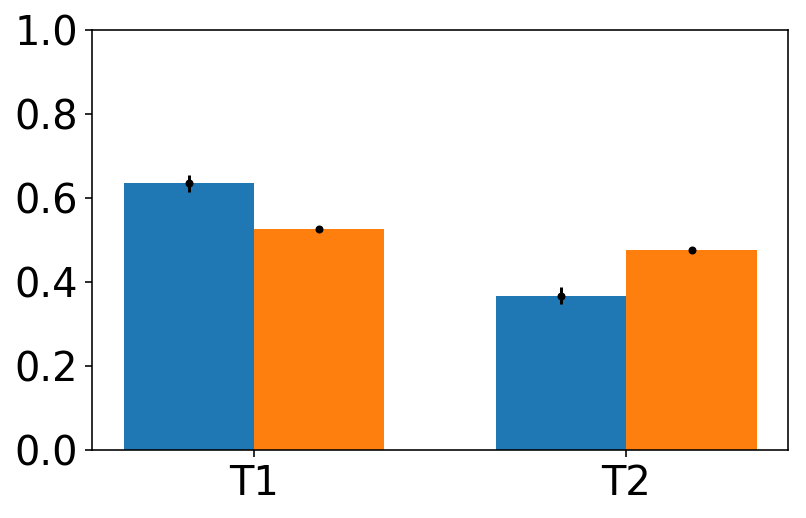

In [586]:
fig, ax = plt.subplots(1, 1, tight_layout=True)

labels = ["T1", "T2"]#, "T3"]

x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

r1 = ax.bar(x - width/2, y, width, label='Cluster')
r2 = ax.bar(x + width/2, yy, width, label='!Cluster')
ax.errorbar(x- width/2, y, yerr=yerr, fmt='.k');
ax.errorbar(x+ width/2, yy, yerr=yyerr, fmt='.k');

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1)

plt.show()